In [ ]:
from utils import *

NOTEBOOK_ID = '09'
RUN_TILING = False
RUN_BASH = False
RUN_MODELS = False

# tile mycocosm

In [ ]:
if RUN_TILING:
    TILE_LEN = 53
    TILE_SPACING = 10
    SLICES = 22

    fasta_dict = {}
    fasta_sequences = SeqIO.parse(open(f'{MYCOCOSM_DIR}/clustered_80/clustered_deduplicated_fungi_90.faa'),'fasta')
    for fasta in tqdm(fasta_sequences,total=6_634_027):
        name, sequence = fasta.id, str(fasta.seq)
        fasta_dict[name] = sequence.replace('*','')
    fasta_dicts = slice_dictionary(fasta_dict, SLICES)
        
    for idx, fastas in tqdm(enumerate(fasta_dicts),total=SLICES):
        seq_df = pd.DataFrame([fastas]).T.reset_index()
        seq_df.columns = ['seq_id','aa_seq']
        seq_df['aa_tiles'] = seq_df['aa_seq'].apply(lambda x: create_protein_tiles(x, TILE_LEN, TILE_SPACING))
        seq_df = seq_df.explode('aa_tiles',ignore_index=True)
        seq_df = seq_df.rename(columns={'aa_tiles':'aa_tile'})
        seq_df = seq_df.dropna(subset='aa_tile')
        seq_df = seq_df[seq_df['aa_tile'].apply(lambda x: len(x)) == TILE_LEN]
        seq_df = seq_df[seq_df['aa_tile'].apply(lambda x: is_protein_sequence(x))]
        seq_df = seq_df.drop_duplicates(subset='aa_tile').reset_index(drop=True)
        seq_df['tile_ID'] = [f'subfile{str(idx).zfill(2)}-' + i.zfill(6) for i in seq_df.index.astype(str)]
        df_to_fasta(f'{MYCOCOSM_DIR}/clustered_90/fungi_subfile{str(idx).zfill(2)}.faa',seq_df, 'tile_ID', 'aa_tile')

In [ ]:
if RUN_BASH:
    os.system(f'cat {MYCOCOSM_DIR}/clustered_90/*subfile*.faa > {MYCOCOSM_DIR}/clustered_90/fungi_tiles_90.faa')
    os.system(f'seqkit rmdup -j 10 -s {MYCOCOSM_DIR}/clustered_90/fungi_tiles_90.faa -o {MYCOCOSM_DIR}/clustered_80/deduplicated_fungi_tiles_90.faa')
    os.system(f'grep -c "^>" {MYCOCOSM_DIR}/clustered_90/deduplicated_fungi_tiles_90.faa | wc -l')

# run predictions on mycocosm

In [ ]:
if RUN_MODELS:
    EMBEDDING_DIR = f'{MYCOCOSM_DIR}/clustered_90/tmp_embeddings'
    seqs = natsorted(glob(f'{MYCOCOSM_DIR}/clustered_90/tmp/*.fasta'), alg=ns.IGNORECASE)
    for slice_seqs in tqdm(seqs):
        handle = slice_seqs.split('/')[-1].replace('.fasta','')
        print(f'======== On subfile: {handle} of {len(seqs)} ========')

        # create embeddings
        print('\t creating embeddings')
        run_esm(in_file=slice_seqs,out_dir=EMBEDDING_DIR)
        
        # load embeddings
        print('\t loading embeddings')
        tmp_df = fasta_to_df(slice_seqs)
        tmp_df['esm_embedding'] = tmp_df['tile_id'].apply(lambda x: get_embedding(EMBEDDING_DIR, x))

        print('\t running model')
        # run model
        # X_test = torch.tensor(np.asarray([emb for emb in tmp_df['esm_embedding']]))
        predictions, uncertainty = get_uncertainty(X_test)

        # save output
        print('\t saving output')
        tmp_df['predictions'] = predictions
        tmp_df['uncertainty'] = uncertainty
        tmp_df.drop(columns=['tile_seq','esm_embedding']).to_csv(f'{MYCOCOSM_DIR}/clustered_90/outputs/{handle}_outputs.csv',index=False)
        print('\t deleting tmp files')

        # delete embeddings
        del_esm()
        del tmp_df

In [6]:
if RUN_BASH:
    os.system(f'grep -c "^>" {MYCOCOSM_DIR}/clustered_90/deduplicated_fungi_tiles_90.faa')

# analyze mycocosm predictions

In [ ]:
if not os.path.isfile(f'{MYCOCOSM_DIR}/03-clustered_90/output_combined.csv'):
    outputs = glob(f'{MYCOCOSM_DIR}/03-clustered_90/outputs/*.csv')
    output_df = None
    for output in tqdm(outputs):
        output_df = pd.concat([output_df, pd.read_csv(output)])

    output_df = output_df.reset_index(drop=True)
    output_df.to_csv(f'{MYCOCOSM_DIR}/03-clustered_90/output_combined.csv',index=False)
    output_df.to_pickle(f'{MYCOCOSM_DIR}/03-clustered_90/output_combined.pkl')
else:
    output_df = pd.read_csv(f'{MYCOCOSM_DIR}/03-clustered_90/output_combined.csv')

In [8]:
if RUN_BASH:
    os.system("grep '^>' '/data/lucas/01-experiments/eLW028-activator_prediction/02-OUTPUT/07-mycocosm/01-clustered_70/clustered_deduplicated_fungi_70.faa'| wc -l")
    os.system("grep '^>' '/data/lucas/01-experiments/eLW028-activator_prediction/02-OUTPUT/07-mycocosm/02-clustered_80/clustered_deduplicated_fungi_80.faa' | wc -l")
    os.system("grep '^>' '/data/lucas/01-experiments/eLW028-activator_prediction/02-OUTPUT/07-mycocosm/03-clustered_90/clustered_deduplicated_fungi_90.faa' | wc -l")
    os.system("grep '^>' '/data/lucas/01-experiments/eLW028-activator_prediction/02-OUTPUT/07-mycocosm/04-results/deduplicated_fungi.faa' | wc -l")

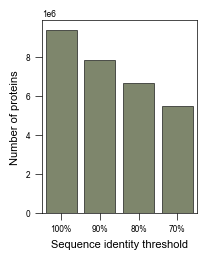

In [9]:
proteins = {}
proteins['70%'] = 5_462_709
proteins['80%'] = 6_634_027
proteins['90%'] = 7_842_516
proteins['100%'] = 9_395_825 # (Deduplicated)
tmp_df = pd.DataFrame([proteins]).T.reset_index()
tmp_df.columns = ['identity_threshold','proteins']

fig = plt.figure(figsize=(2,2.5))
g = sns.barplot(data=tmp_df.sort_values('proteins',ascending=False),
            x='identity_threshold',
            y='proteins',
            color='#69764d',
            edgecolor='black',
            linewidth=0.5,
            alpha=0.85)
g.set(xlabel='Sequence identity threshold',ylabel='Number of proteins')

if SAVE_FIGURES:
    fig.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-mycocosm_clustering.png',**FIGURE_PARAMS)

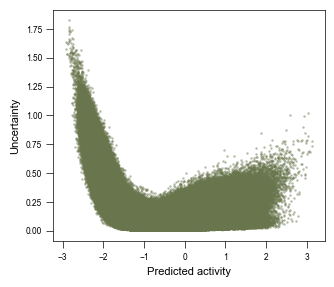

In [10]:
plt.figure(figsize=(3.5,3))
g = sns.scatterplot(data=output_df,x='predictions',y='uncertainty',s=3,alpha=0.5,color='#69764d',linewidth=0)
g.set(xlabel='Predicted activity',ylabel='Uncertainty')
    
if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-mycocosm_search.png',**FIGURE_PARAMS)

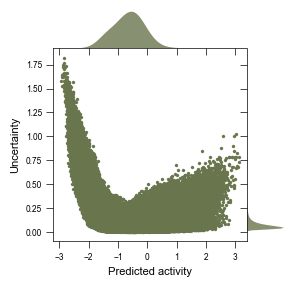

In [11]:
fig = plt.figure(figsize=(3, 3))
gs = fig.add_gridspec(6, 6)
test = output_df
ax_joint = fig.add_subplot(gs[1:6, 0:5])
g = sns.scatterplot(data=test,
                    x='predictions',
                    y='uncertainty',
                    s=5,
                    color='#69764d',
                    edgecolor=None,
                    ax=ax_joint)
loc = ticker.MultipleLocator(base=1)
g.xaxis.set_major_locator(loc)
g.set_xlim(-3.2,3.4)
g.set(xlabel='Predicted activity',ylabel='Uncertainty')
ax_joint.spines['top'].set_visible(False)
ax_joint.spines['right'].set_visible(False)

ax_marg_x = fig.add_subplot(gs[0, 0:5], sharex=ax_joint)
g = sns.kdeplot(data=test,
                x='predictions',
                ax=ax_marg_x,
                color='#69764d',
                multiple='stack',
                edgecolor=None,
                alpha=0.8)
g.set(xlabel=None,ylabel=None,yticklabels=[],yticks=[])
ax_marg_x.xaxis.set_tick_params(labelbottom=False)
ax_marg_x.spines['top'].set_visible(False)
ax_marg_x.spines['right'].set_visible(False)
ax_marg_x.spines['left'].set_visible(False)

ax_marg_y = fig.add_subplot(gs[1:6, 5],sharey=ax_joint)
g = sns.kdeplot(data=test,
                y='uncertainty',
                ax=ax_marg_y,
                color='#69764d',
                multiple='stack',
                edgecolor=None,
                alpha=0.8)
g.set(ylabel=None,xlabel=None,xticklabels=[],xticks=[])
ax_marg_y.yaxis.set_tick_params(labelbottom=False)
ax_marg_y.spines['top'].set_visible(False)
ax_marg_y.spines['right'].set_visible(False)
ax_marg_y.spines['bottom'].set_visible(False)

plt.subplots_adjust(hspace=0, wspace=0)
if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-mycocosm_search_jointplot.png',**FIGURE_PARAMS)